# Belief Propagation from Geo-Located Imagery

In [1]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray

import demo_functions as df

__________
Let's begin with the input parameters. These include the label file, confidence in the labels and the data types we will use. Once we confirm the data types we will be asked for paths to the files containing the imagery. Post-event must be provided but pre-event is optional. If a pre-event image is provided the data used will be the difference between the images which contains more information than the post event image alone.

In [2]:
inputs = df.parameter_input()

HTML(value='<b>Label Parameters</b>')

Box(children=(Label(value='Damage Labels: Shapefile - '), Text(value='./data/beirutDamages.shp', layout=Layout…

Box(children=(Label(value='Label Confidence ($P_{other label}$, $P_{class}$)'), FloatRangeSlider(value=(0.0, 1…

HTML(value='<b>Map Properties</b>')

Box(children=(Label(value='Latitude - '), FloatText(value=33.893, layout=Layout(width='max-content')), Label(v…

HTML(value='<b>Data Parameters</b>')

Box(children=(Label(value='Enter Data Types:'), Combobox(value='HighRes Imagery', layout=Layout(width='max-con…

______
Now let's load up the map of our ground labels and define an area for the model. Then below the map we'll pick the model parameter to run on the data from the selected area. If we wish to group classes together we will also be offered some clustering options.

In [3]:
parameters = df.model_parameters(inputs)

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

HTML(value='<h3>Model Parameters</h3>')

HTML(value='<b>Node Properties</b>')

Box(children=(Label(value='Maximum nodes - Sampling occurs if < pixel number: '), IntText(value=20000, layout=…

HTML(value='<b>Edge Properties</b>')

Box(children=(Label(value='Neighbours - Edges to nearest values for each node: '), Box(children=(IntText(value…

Box(children=(Label(value='Geographical Edges - '), Checkbox(value=False, indent=False, layout=Layout(width='m…

HTML(value='<b>Class Properties</b>')

HTML(value="Label Classes - ['GREEN' 'YELLOW' 'LAND' 'RED' 'TOTAL']")

Box(children=(Label(value='Classes for Model - '), Dropdown(index=3, options=(2, 3, 4, 5), value=5)))

________
Now we have all the parameters for the model, let's import and classify the data according to our selections. If you have already imported the data and just adjusted the model parameters then just re-classify rather than re-importing.

In [6]:
imports = df.import_data(parameters)

------Checking Coordinate Systems-------
------Finished Checking Coordinate Systems-------
------Importing Data Files---------
data/highRes/20AUG05_HR_LatLon.tif read completed.
data/highRes/20JUL31_HR_LatLon.tif read completed.


/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  coro.send(None)


./data/beirutPrePostExplosionIfg.tif read completed.
./data/beirutPrePreExplosionIfg.tif read completed.
------Finished Data Import---------


In [7]:
classified = df.classify_data(imports)

------Data Sampling---------
------Data Classification---------
------Finished Data Classification---------


____________
OK, the data is formatted the model parameters are all checked. Let's build the graph of nodes & edges and run the belief propagation!

In [8]:
output = df.run_bp(classified)

Nodes: 20000, Edges: 120000
It	Loss	Label change

0	2.92663e+00		1979

1	1.21071e-01		97

2	6.80422e-01		19

3	2.54815e-02		0

4	1.60972e-01		0

5	9.62540e-03		0

6	3.84649e-02		0

7	4.22631e-03		0

8	9.28896e-03		0

9	1.46927e-03		0

10	2.26601e-03		0

11	4.61816e-04		0

Time elapsed: 9.446805238723755 seconds


_____
Now let's use the test set to evaluate the effectiveness of the model.

              precision    recall  f1-score   support

       GREEN       0.85      0.95      0.90      1923
        LAND       0.15      0.04      0.06       138
         RED       0.08      0.04      0.06        45
       TOTAL       0.00      0.00      0.00         2
      YELLOW       0.07      0.03      0.04       156

    accuracy                           0.81      2264
   macro avg       0.23      0.21      0.21      2264
weighted avg       0.74      0.81      0.77      2264



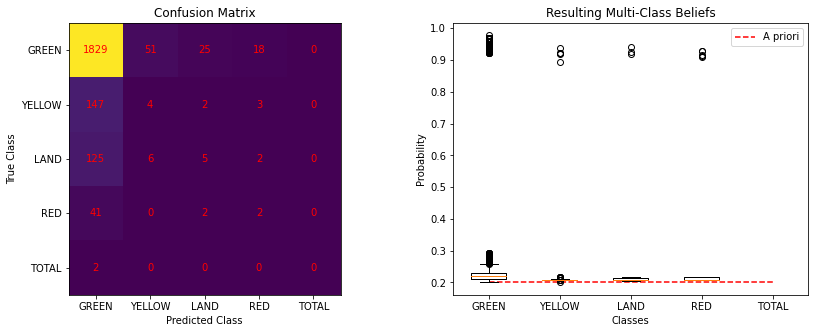

In [9]:
plots = df.evaluate_output(output)

Want to save the plot? Run the cell below. If you want to specify a location replace the False boolean with the filepath.

In [ ]:
df.save_plot(plots, location=False)

In [167]:
# Visualise spatial results
import plotting as pl
for i in plots.keys(): globals()[i] = plots[i] # Retrieve variables to use
from ipyleaflet import LayersControl
import ipywidgets as ipw

mf = pl.create_map(lat, lon, zoom)

plot_assessments(labels, mf, cn=cn, layer_name='Ground truth', layer_only=True)

plot_assessments(nodes.to_crs({'init':crs}).dropna(), mf, layer_name='Train Locations', no_leg=True)

import geopandas as gpd
a = gpd.sjoin(initial, X_test, how='left', op='within').dropna(subset=[cn])
a['prediction']=pred_clf
plot_assessments(a.to_crs({'init':crs}).dropna(), mf, cn='prediction', layer_name='Test Predictions', no_leg=True)

control = ipl.LayersControl(position='topright')

mf.add_control(control)

zoom_slider = ipw.IntSlider(description='Zoom level:', min=7, max=18, value=14)
ipw.jslink((zoom_slider, 'value'), (mf, 'zoom'))
widget_control1 = ipl.WidgetControl(widget=zoom_slider, position='topright')
mf.add_control(widget_control1)
mf.add_control(ipl.FullScreenControl())
mf

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [164]:
import ipyleaflet as ipl
# Converting gdf columns to GeoData for plotting
def to_geodata(gdf, color, name='Data'):
    plotGdf = ipl.GeoData(geo_dataframe = gdf,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':0.9, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.8, 'fillColor': color, 'weight': 3},
                          name = name)
    return plotGdf

# Plotting for building footprints with attached assessments
def plot_assessments(gdf, mapName, cn='decision', classes=['GREEN','YELLOW','RED','TOTAL','LAND'], colors=['green','yellow','red','maroon','cyan'], layer_name='Data', layer_only=False, no_leg=False):
    classes = inputs['labels']['decision'].unique() if classes is False else classes 
    leg = {}
    globals()['layer'+layer_name] = ipl.LayerGroup(name = layer_name)
    for i, cl in enumerate(classes):
        globals()['layer'+layer_name].add_layer(to_geodata(gdf.loc[gdf[cn].str.contains(cl)],colors[i],layer_name))
        leg.update({cl:colors[i]})
    if not layer_only:
        mapName.add_layer(globals()['layer'+layer_name])
        if not 'l1' in globals() and no_leg is False: # Add legend if forming map for first time
            l1 = ipl.LegendControl(leg, name=cn, position="bottomleft")
            mapName.add_control(l1)
        return mapName
    else: return globals()['layer'+layer_name]